In [376]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import glob
import json
import re
import os
from PIL import Image
from scipy.spatial.transform import Rotation as R


def rmat_and_inv(rotation_y):
    '''rotation_y: radian'''
    euler_angle = [0,0, rotation_y]
    rot = R.from_euler('xyz', euler_angle, degrees=False)  # type: ignore
    rot_inv = rot.inv()
    rmat = np.array(rot.as_matrix())
    rmat_inv = np.array(rot_inv.as_matrix())

    return rmat, rmat_inv


def get_3d_corners(location, dimension, rmat):
    '''location: [x, y, z]
        dimension: [w, h, l]
        rmat: rotation matrix
        extra_range: [l, w, h]에 추가로 더할 값'''

    x = location[0]
    y = location[1]
    z = location[2]
    l = dimension[2]
    w = dimension[0]
    h = dimension[1]

    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]
    z_corners = [h/2, h/2, h/2, h/2, -h/2, -h/2, -h/2, -h/2]
    corners_3d = np.dot(rmat, np.vstack([x_corners, y_corners, z_corners]))
    corners_3d[0, :] = corners_3d[0, :] + x
    corners_3d[1, :] = corners_3d[1, :] + y
    corners_3d[2, :] = corners_3d[2, :] + z

    return corners_3d


def box_select(box_list, cat): # box_list: "3d_box", cat: "category"
    if cat=="MEDIAN_STRIP" or cat=="SOUND_BARRIER":
        dist = []
        for box in box_list:
            dist.append(box["location"][0])
        idx = dist.index(min(dist))
        # 중앙분리대, 방음벽의 길이를 15m로 고정
        new_x = box_list[idx]['location'][0] - box_list[idx]['dimension'][2]/2 + 7.5
        new_l = 15
        box_list[idx]['location'][0] = new_x
        box_list[idx]['dimension'][2] = new_l
        return box_list[idx]
    elif cat=='RAMP_SECT':
        dist = []
        for box in box_list:
            dist.append(box["location"][1])
        idx = dist.index(min(dist))
        return box_list[idx]
    elif cat=="OVERPASS" or cat=="TUNNEL":
        width = []
        for box in box_list:
            width.append(box["dimension"][0])
        idx = width.index(max(width))
        return box_list[idx]
    else:
        return box_list[0]

In [381]:
key

'/data/kimgh/CenterPoint-custom/CenterPoint-static/data/selectsub3/test/source/normal/11/A_Clip_00399_11/Lidar/2-048_00399_LR_066'

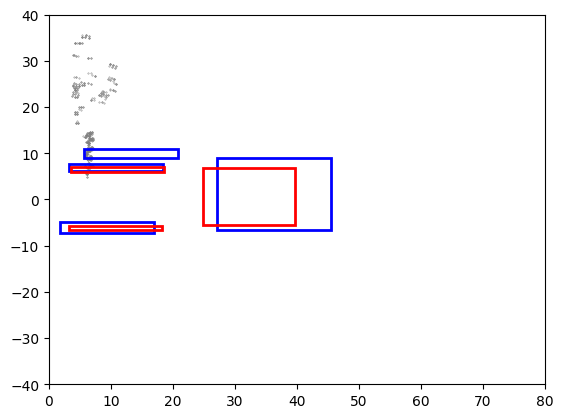

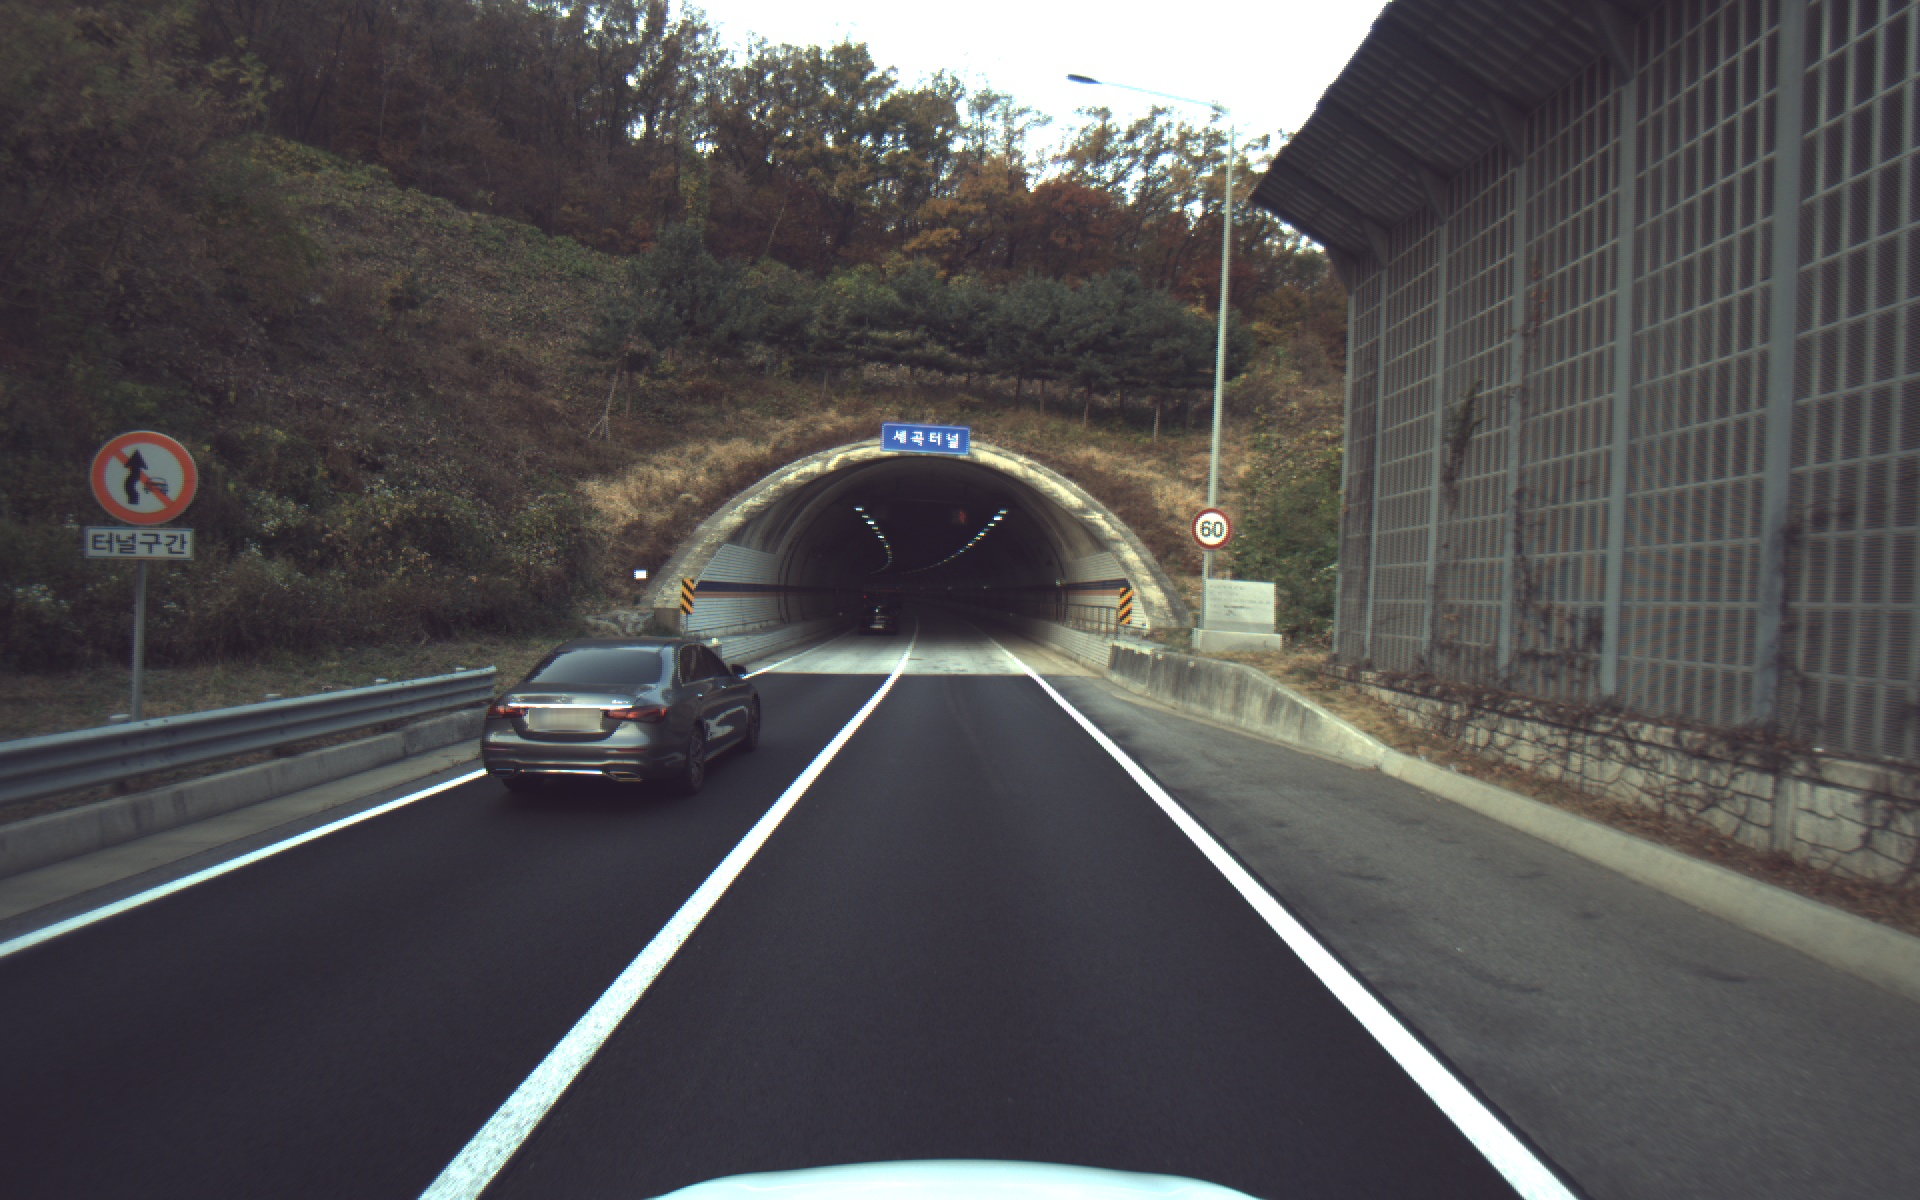

/data/kimgh/CenterPoint-custom/CenterPoint-static/data/selectsub5/test/source/normal/13/A_Clip_22301_13/Radar/RadarFront/2-048_22301_RF_027
5104


In [426]:
with open('/data/kimgh/CenterPoint-custom/CenterPoint-static/result/selectsub5/test/radar/normal_epoch200/prediction_radar.pkl', 'rb') as f:
    preds = pickle.load(f)

key_num = np.random.choice(range(len(preds)))
# key_num = 3511

key = list(preds.keys())[key_num]
pred = preds[key]
scores = pred['scores']
select_obj = np.where(scores >= 0.4)
box3d_lidar = pred['box3d_lidar'][select_obj]


scene = re.search('[A|S_Clip]+_[0-9]+_[0-9]+', key)[0]
status = re.search('normal|abnormal', key)[0]
frame = int(key[-3:])
if 'Lidar' in key:
    lidar_path = sorted(glob.glob(f'/data/NIA48/raw/test/source/{status}/{scene[-2:]}/{scene}/Lidar/*'))[frame-1]
else:
    lidar_path = sorted(glob.glob(f'/data/NIA48/raw/test/source/{status}/{scene[-2:]}/{scene}/Radar/RadarFront/*'))[frame-1]
label_path = sorted(glob.glob(f'/data/NIA48/raw/test/label/{status}/{scene[-2:]}/{scene}/result/*'))[frame-1]
image_path = sorted(glob.glob(f'/data/NIA48/raw/test/source/{status}/{scene[-2:]}/{scene}/Camera/CameraFront/blur/*'))[frame-1]

lidar = o3d.io.read_point_cloud(lidar_path)
# radar = o3d.io.read_point_cloud(radar_path)
with open(label_path, 'rb') as f:
    label = json.load(f)

lidar_pcd = np.asarray(lidar.points)[:, :3]
# radar_pcd = np.asarray(radar.points)[:, :3]

anns = label['annotation']


fig, ax = plt.subplots()
# ax.add_patch(mpathes.Rectangle(bev_box[0:2], bev_box[2], bev_box[3], fill=False, color='black', linewidth=2))
ax.scatter(lidar_pcd[:, 0], lidar_pcd[:, 1], s=0.1, color='gray')

for box in box3d_lidar:
    box = np.asarray(box)
    x = box[0]
    y = box[1]
    z = box[2]
    l = box[3]
    w = box[4]
    h = box[5]
    rot = box[-1]

    rmat = rmat_and_inv(rot)[0]
    corners_3d = get_3d_corners([x, y, z], [w, h, l], rmat)

    xmin, xmax, ymin, ymax = np.min(corners_3d[0, :]), np.max(corners_3d[0, :]), np.min(corners_3d[1, :]), np.max(corners_3d[1, :])
    polygon = [[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]]

    shape = patches.Polygon(polygon, linewidth=2, edgecolor='blue', fill=False)
    ax.add_patch(shape)

for ann in anns:
    box_3d = ann['3d_box']
    box_3d = box_select(box_3d, ann['category'])

    x = box_3d['location'][0]
    y = box_3d['location'][1]
    z = box_3d['location'][2]
    l = box_3d['dimension'][2]
    w = box_3d['dimension'][0]
    h = box_3d['dimension'][1]
    rot = box_3d['rotation_y']

    rmat = rmat_and_inv(rot)[0]
    corners_3d = get_3d_corners([x, y, z], [w, h, l], rmat)

    xmin, xmax, ymin, ymax = np.min(corners_3d[0, :]), np.max(corners_3d[0, :]), np.min(corners_3d[1, :]), np.max(corners_3d[1, :])
    polygon = [[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]]

    shape = patches.Polygon(polygon, linewidth=2, edgecolor='red', fill=False)
    ax.add_patch(shape)

ax.set_xlim(0, 80)
ax.set_ylim(-40, 40)
plt.show()

image = Image.open(image_path)
image.resize((800, 400))
image.show()

print(key)
print(key_num)